# Pair Mean Reversion
* This works better in long-term equity trading, but it is much less useful in intraday because of microstructure noise. For now we fit it into the intraday trading to align with other strategies and mainly use it as an opportunity to explore Kalman filter.

## 1 Notations

### 1.1 Kalman filter
#### State equation
* $\theta_{t} = \theta_{t-1} + \omega_{t}$
* $\omega_{t} \sim \mathcal{N}(0, Q)$
* $\theta = \begin{bmatrix} \alpha_{t} \\ \beta_{t} \end{bmatrix}$
* $Q$ = state noise covariance
#### Observation equation
* $P_{A}(t) = \begin{bmatrix} 1 & P_{B}(t) \end{bmatrix} \cdot \theta_{t} + \nu_{t}$
* $\nu_{t} \sim \mathcal{N}(0, R)$
* $R$ = observation noise
#### Prior
* $\hat{\theta}_{t \mid t-1} = \hat{\theta}_{t-1 \mid t-1}$
* $P_{t \mid t-1} = P_{t-1 \mid t-1} + Q$
#### Posterior
* Innovation: $y_{t} = P_{A}(t) - \begin{bmatrix} 1 & P_{B}(t) \end{bmatrix} \cdot \hat{\theta}_{t \mid t-1}$
* Innovation covariance $S_{t} = \begin{bmatrix} 1 & P_{B}(t) \end{bmatrix} \cdot P_{t \mid t-1} \cdot \begin{bmatrix} 1 & P_{B}(t) \end{bmatrix}^{T} + R$
* Kalman gain: $K_{t} = P_{t \mid t-1} \cdot \begin{bmatrix} 1 & P_{B}(t) \end{bmatrix}^{T} \cdot S_{t}^{-1}$
* Update state: $\hat{\theta}_{t \mid t} = \hat{\theta}_{t \mid t-1} + K_{t} \cdot y_{t}$
* Update covariance: $P_{t \mid t} = (I - K_{t} \cdot \begin{bmatrix} 1 & P_{B}(t) \end{bmatrix}) \cdot P_{t \mid t-1}$
### 1.2 Trading with Kalman filter
* Spread $S_{t} = P_{A}(t) - \alpha_{t} - \beta_{t} \cdot P_{B}(t)$
* Z-score $Z_{t} = \frac{S_{t} - \mu_{S}}{\sigma_{S}}$

## 2 Strategy

## 3 Codes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 3.1 Data Management
* Each csv file has its name in the `"YYYY-MM-DD.csv"` format
* It has columns: `["ticker", "volume", "open", "close", "high", "low", "window_start", "transactions"]`
* `"ticker"` includes the minute bar aggregate of every ticker symbol of US stocks on the given day
* `"window_start"` is epoch time in ns

In [2]:
def datafeed(file_name, ticker_symbol):
    df = pd.read_csv(file_name)
    df = df[df["ticker"] == ticker_symbol]
    df["window_start"] = pd.to_datetime(df["window_start"], unit="ns")
    df = df.set_index("window_start").sort_index()
    df = df.between_time("09:30", "16:00")
    return df

### 3.2 Kalman filter
* Kalman filter for time-varying regression: `y_t = alpha_t + beta_t * x_t + noise`.
* State: `theta_t = [alpha_t, beta_t]^T`, random walk with `diag(Q) = [q_alpha, q_beta]`.

#### Parameters
* `y`, `x`: Aligned series (price or log-price). NaNs will be dropped row-wise.
* `q_alpha`, `q_beta`: State noise variances for alpha and beta (larger => faster adaptation).
* `r_var`: Observation noise variance R.
* `theta0`: Initial state (2,), `default = [0., 1.]`.
* `P0`: Initial covariance (2x2), `default = 1e6 * I`.
* `z_window`: Rolling window for z-score of the residual spread.

#### Returns
* `pd.DataFrame` with columns: `alpha`, `beta`, `spread`, `innov`, `innov_var`, `z`

In [3]:
def kalman_filter(y: pd.Series,
                x: pd.Series,
                q_alpha: float = 1e-7,
                q_beta: float = 1e-7,
                r_var: float = 1e-4,
                theta0: np.ndarray | None = None,
                P0: np.ndarray | None = None,
                z_window: int = 60) -> pd.DataFrame:

    df = pd.concat({"y": y, "x": x}, axis=1).dropna()
    yv = df["y"].to_numpy(dtype=float)
    xv = df["x"].to_numpy(dtype=float)

    n = len(df)
    alpha = np.zeros(n)
    beta = np.zeros(n)
    spread = np.zeros(n)
    innov = np.zeros(n)
    innov_var = np.zeros(n)

    # Initialize
    theta = np.array([0., 1.]) if theta0 is None else np.asarray(theta0, dtype=float)
    P = (1e6 * np.eye(2)) if P0 is None else np.array(P0, dtype=float)

    Q = np.diag([q_alpha, q_beta]) # state noise
    R = r_var # observation noise (scalar)

    for t in range(n):
        H = np.array([[1.0, xv[t]]]) # design row (1x2)

        # Predict
        theta_prior = theta # F = I, so theta stays same
        P_prior = P + Q

        # Innovation
        y_hat = (H @ theta_prior).item() # scalar
        v_t = yv[t] - y_hat # innovation
        S_t = (H @ P_prior @ H.T + R).item() # scalar innovation variance

        # Kalman gain
        K = (P_prior @ H.T) / S_t # (2x1)

        # Update
        theta = theta_prior + (K.flatten() * v_t)
        P = (np.eye(2) - K @ H) @ P_prior

        alpha[t], beta[t] = theta
        spread[t] = yv[t] - (alpha[t] + beta[t] * xv[t])
        innov[t] = v_t
        innov_var[t] = S_t

    out = df.copy()
    out["alpha"] = alpha
    out["beta"]  = beta
    out["spread"] = spread

    # z-score of the model residual (spread)
    out["spread_mean"] = out["spread"].rolling(z_window, min_periods=z_window//3).mean()
    out["spread_std"]  = out["spread"].rolling(z_window, min_periods=z_window//3).std(ddof=1)
    out["z"] = (out["spread"] - out["spread_mean"]) / out["spread_std"]

    # Innovation-based diagnostic
    out["innov"] = innov
    out["innov_var"] = innov_var

    return out

### 3.3 Transaction Log
* We initialize a log with a cash amount of choice and a position of 0
* We use a helper function to calculate the real time equity based on position and price

#### Columns
* `cash`: cash balance
* `pos_y`: position (shares) in asset Y (can be + or -)
* `pos_x`: position (shares) in asset X (can be + or -)
* `price_y`: last traded price of Y
* `price_x`: last traded price of X
* `equity`: `total equity = cash + pos_y*price_y + pos_x*price_x`
* `status`: free text flag ("OK", "COOLDOWN", etc.)

In [4]:
def create_pair_log(df_data: pd.DataFrame,
                    initial_cash: float,
                    y_col: str = "y",
                    x_col: str = "x") -> pd.DataFrame:

    idx = df_data.index

    df_log = pd.DataFrame(
        np.nan,
        index=idx,
        columns=[
            "cash",
            "pos_y", "pos_x",
            "price_y", "price_x",
            "equity",
            "status",
        ],
    )

    df_log["status"] = pd.Series(index=idx, dtype="object")
    
    first = df_log.index[0]

    # Start flat with all cash
    df_log.at[first, "cash"] = float(initial_cash)
    df_log.at[first, "pos_y"] = 0.0
    df_log.at[first, "pos_x"] = 0.0

    # Use the first available prices for bookkeeping
    df_log.at[first, "price_y"] = float(df_data.at[first, y_col])
    df_log.at[first, "price_x"] = float(df_data.at[first, x_col])

    # Initial equity = initial cash
    df_log.at[first, "equity"] = float(initial_cash)

    # Set default status
    df_log["status"] = "OK"

    return df_log

* This recomputes total equity off both legs plus cash, allowing positive/negative positions (long/short) naturally.

In [5]:
def update_pair_equity(df_log: pd.DataFrame) -> pd.DataFrame:

    # Notional exposures on each leg
    notional_y = df_log["pos_y"] * df_log["price_y"]
    notional_x = df_log["pos_x"] * df_log["price_x"]

    df_log["equity"] = df_log["cash"] + notional_y + notional_x

    return df_log

### 3.4 Paper Broker Orders
* We simultaneously write to the log whenever an order is executed

In [6]:
def pair_execute(df_data, df_log, index,
                 qty_y: float, qty_x: float,
                 y_col: str = "y", x_col: str = "x"):

    price_y = float(df_data.at[index, y_col])
    price_x = float(df_data.at[index, x_col])

    # set current mark prices
    df_log.at[index, "price_y"] = price_y
    df_log.at[index, "price_x"] = price_x

    # update positions
    df_log.at[index, "pos_y"] += qty_y
    df_log.at[index, "pos_x"] += qty_x

    # update cash: buying uses cash, selling adds cash
    df_log.at[index, "cash"] -= qty_y * price_y
    df_log.at[index, "cash"] -= qty_x * price_x

    # recompute equity
    update_pair_equity(df_log)
    return df_log

* `open_long_spread`: long spread = long Y, short X (using hedge ratio beta).

In [7]:
def open_long_spread(df_data, df_log, index,
                     beta: float,
                     dollar_notional: float,
                     y_col: str = "y", x_col: str = "x"):

    price_y = float(df_data.at[index, y_col])
    price_x = float(df_data.at[index, x_col])

    # Simple allocation: target |pos_y| and |pos_x| based on beta
    denom = price_y + abs(beta) * price_x
    shares_y = dollar_notional / denom # > 0
    shares_x = -beta * shares_y # usually < 0

    # round to integers
    shares_y = int(shares_y)
    shares_x = int(shares_x)

    return pair_execute(df_data, df_log, index, shares_y, shares_x,
                        y_col=y_col, x_col=x_col)

* `open_short_spread`: short spread = short Y, long X (reverse of long spread).

In [8]:
def open_short_spread(df_data, df_log, index,
                      beta: float,
                      dollar_notional: float,
                      y_col: str = "y", x_col: str = "x"):

    price_y = float(df_data.at[index, y_col])
    price_x = float(df_data.at[index, x_col])

    denom = price_y + abs(beta) * price_x
    shares_y = -(dollar_notional / denom) # < 0 (short Y)
    shares_x = -beta * shares_y # > 0 (long X)

    shares_y = int(shares_y)
    shares_x = int(shares_x)

    return pair_execute(df_data, df_log, index, shares_y, shares_x,
                        y_col=y_col, x_col=x_col)

* `close_spread`: close whatever pair position we currently have; trade back to zero in both legs.

In [9]:
def close_spread(df_data, df_log, index,
                 y_col: str = "y", x_col: str = "x"):

    qty_y = -df_log.at[index, "pos_y"]
    qty_x = -df_log.at[index, "pos_x"]

    return pair_execute(df_data, df_log, index, qty_y, qty_x,
                        y_col=y_col, x_col=x_col)

### 3.5 Strategy Execution
* For now, the execution only works with the log because of the paper broker orders
* `execute_kalman_pair_strategy`: assumes df_kf has at least columns `["y", "x", "z"]` and index is a `DatetimeIndex` aligned to the trading minutes.

#### Trading logic
* If not in a trade: `z >= +z_entry` -> short spread; `z <= -z_entry` -> long spread
* If in a trade: `|z| <= z_exit or last bar` -> close both legs

#### Positions
* `pos_y > 0`: long y; `pos_y < 0`: short y
* `pos_x > 0`: long x; `pos_x < 0`: short x
* Cash: increases when we sell/short, decreases when we buy/cover.

In [10]:
def execute_kalman_pair_strategy(
    df_kf: pd.DataFrame,
    initial_cash: float = 10_000.0,
    z_entry: float = 2.0,
    z_exit: float = 0.5,
    dollar_per_leg: float = 5_000.0,
) -> pd.DataFrame:

    idx = df_kf.index

    # Pair transaction log tied to the paper broker
    df_log = pd.DataFrame(
        np.nan,
        index=idx,
        columns=["cash", "pos_y", "pos_x", "price_y", "price_x", "equity", "status"],
    )

    df_log["status"] = pd.Series(index=idx, dtype="object")

    # Initialize first row
    first = idx[0]
    price_y0 = float(df_kf.at[first, "y"])
    price_x0 = float(df_kf.at[first, "x"])

    df_log.at[first, "cash"] = initial_cash
    df_log.at[first, "pos_y"] = 0.0
    df_log.at[first, "pos_x"] = 0.0
    df_log.at[first, "price_y"] = price_y0
    df_log.at[first, "price_x"] = price_x0
    df_log.at[first, "equity"] = initial_cash
    df_log.at[first, "status"] = "INIT"

    in_trade = False
    trade_side = None # "long_spread" or "short_spread"

    prev_t = first

    for t in idx[1:]:
        # Carry forward previous log state
        df_log.loc[t, ["cash", "pos_y", "pos_x", "price_y", "price_x", "equity", "status"]] = \
            df_log.loc[prev_t, ["cash", "pos_y", "pos_x", "price_y", "price_x", "equity", "status"]]

        cash   = float(df_log.at[t, "cash"])
        pos_y  = float(df_log.at[t, "pos_y"])
        pos_x  = float(df_log.at[t, "pos_x"])

        price_y = float(df_kf.at[t, "y"])
        price_x = float(df_kf.at[t, "x"])
        z       = df_kf.at[t, "z"]

        # Update current prices
        df_log.at[t, "price_y"] = price_y
        df_log.at[t, "price_x"] = price_x

        # If z or prices are missing, just update equity and continue
        if (not np.isfinite(z)) or (not np.isfinite(price_y)) or (not np.isfinite(price_x)):
            df_log.at[t, "equity"] = cash + pos_y * price_y + pos_x * price_x
            prev_t = t
            continue

        # Helper to apply a pair trade (delta shares in y and x)
        def apply_pair_trade(delta_y: float, delta_x: float, label: str):
            nonlocal cash, pos_y, pos_x

            # trade_cash = - sum(delta_pos * price)
            trade_cash_y = -delta_y * price_y
            trade_cash_x = -delta_x * price_x

            cash += trade_cash_y + trade_cash_x
            pos_y += delta_y
            pos_x += delta_x

            df_log.at[t, "cash"] = cash
            df_log.at[t, "pos_y"] = pos_y
            df_log.at[t, "pos_x"] = pos_x
            df_log.at[t, "status"] = label

        # Trading rules
        if not in_trade:
            # ENTRY
            if z >= z_entry:
                # Spread is high: y expensive relative to x -> short spread
                # Long x, short y
                shares_y = dollar_per_leg / price_y
                shares_x = dollar_per_leg / price_x

                # Round to whole shares
                shares_y = np.floor(shares_y)
                shares_x = np.floor(shares_x)

                if shares_y > 0 and shares_x > 0:
                    apply_pair_trade(delta_y=-shares_y, # short y
                                     delta_x=+shares_x, # long x
                                     label=f"OPEN_SHORT z={z:.2f}")
                    in_trade = True
                    trade_side = "short_spread"

            elif z <= -z_entry:
                # Spread is low: y cheap relative to x -> long spread
                # Long y, short x
                shares_y = dollar_per_leg / price_y
                shares_x = dollar_per_leg / price_x

                shares_y = np.floor(shares_y)
                shares_x = np.floor(shares_x)

                if shares_y > 0 and shares_x > 0:
                    apply_pair_trade(delta_y=+shares_y, # long y
                                     delta_x=-shares_x, # short x
                                     label=f"OPEN_LONG z={z:.2f}")
                    in_trade = True
                    trade_side = "long_spread"

        else:
            # EXIT
            last_bar = (t == idx[-1])
            if (abs(z) <= z_exit) or last_bar:
                # Close both legs: trade deltas are minus current positions
                apply_pair_trade(delta_y=-pos_y, delta_x=-pos_x,
                                 label=f"CLOSE_{trade_side} z={z:.2f}")
                in_trade = False
                trade_side = None

        # Update equity after any trades
        df_log.at[t, "equity"] = cash + pos_y * price_y + pos_x * price_x

        prev_t = t

    return df_log

## 4 Backtest
* In a pair (e.g., AAPL, MSFT), choose x = the more stable / explanatory / lower-volatility asset, and y = the more volatile / explained asset.

In [11]:
backtest_data_y = datafeed("data/2025-09-03.csv", "AAPL")
backtest_data_x = datafeed("data/2025-09-03.csv", "MSFT")

In [12]:
# Choose y and x from the backtest data
y_close = backtest_data_y["close"]
x_close = backtest_data_x["close"]

In [13]:
# Run Kalman filter on the closes
kf_out = kalman_filter(
    y=y_close,
    x=x_close,
    q_alpha=1e-7,
    q_beta=1e-7,
    r_var=1e-4,
    z_window=60,
)

In [14]:
df_kf = kf_out.copy()

# Align prices to the Kalman index (just in case)
df_kf["y"] = y_close.reindex(df_kf.index)
df_kf["x"] = x_close.reindex(df_kf.index)

# Drop rows where we don't have prices or z-score
df_kf = df_kf.dropna(subset=["y", "x", "z"])

In [15]:
# Run the execution logic
pair_log = execute_kalman_pair_strategy(
    df_kf=df_kf,
    initial_cash=10_000.0,
    z_entry=2.0,
    z_exit=0.5,
    dollar_per_leg=5_000.0,
)

## 5 Result Visualization

In [16]:
# Basic backtest summary
start_eq = float(pair_log["equity"].iloc[0])
end_eq = float(pair_log["equity"].iloc[-1])
pnl = end_eq - start_eq
n_trades = pair_log["status"].fillna("").str.contains("OPEN_").sum()

print(f"Start equity : {start_eq:,.2f}")
print(f"End equity   : {end_eq:,.2f}")
print(f"PnL          : {pnl:,.2f}")
print(f"# trades     : {n_trades}")

Start equity : 10,000.00
End equity   : 9,962.96
PnL          : -37.04
# trades     : 13


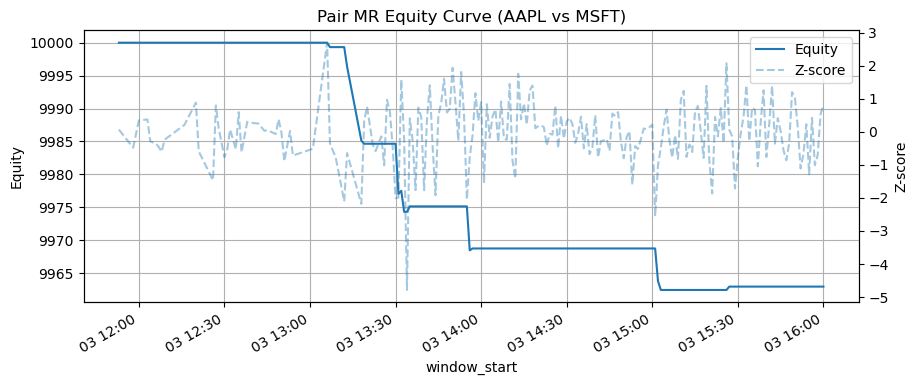

In [17]:
# Simple plots: equity curve and z-score
ax = pair_log["equity"].plot(figsize=(10, 4), grid=True, label="Equity")
ax.set_title("Pair MR Equity Curve (AAPL vs MSFT)")
ax.set_ylabel("Equity")

ax2 = ax.twinx()
df_kf["z"].plot(ax=ax2, alpha=0.4, style="--", label="Z-score")
ax2.set_ylabel("Z-score")

# Combine legends from both axes
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc="best")

## 6 Notes